In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

cwd = os.getcwd()
df = pd.read_csv(cwd + "/data_csv/preprocessing_data.csv")

emo_feature = []
emo_target = []

for i in range(len(df['emotion'])):
    if df['emotion'][i] == 3:
        emo_target.append(1)
    else:
        emo_target.append(0)
        
    emo_feature.append([df['mouth_distance'][i], df['average_distance'][i]])

emo_feature = np.array(emo_feature)
emo_target = np.array(emo_target)

# import data
X = emo_feature
y = emo_target

# Add noisy features
random_state = np.random.RandomState(0)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)

C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

====================Fold 1==================== 

accuracy_score : 0.9884125144843569
log_loss : 0.06461717594332855



C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

====================Fold 2==================== 

accuracy_score : 0.9826187717265353
log_loss : 0.08168705366362165



C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

====================Fold 3==================== 

accuracy_score : 0.9745075318655851
log_loss : 0.12468858601671827



C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

====================Fold 4==================== 

accuracy_score : 0.984936268829664
log_loss : 0.07639964789491559

====================Fold 5==================== 

accuracy_score : 0.9837775202780996
log_loss : 0.0826707851492353



C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

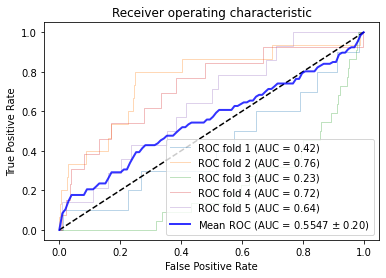

accuracy : 0.98125


In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn import svm
import matplotlib.pyplot as plt

# create model
clf = svm.SVC(kernel='linear', C=1, probability=True)

history = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5, shuffle=True)
for i, (train, val) in enumerate(cv.split(X_train, y_train)):
    X_train, X_val = X[train], X[val]
    y_train, y_val = y[train], y[val]

    # Fit model
    clf.fit(X_train, y_train)

    # Predict
    predict = clf.predict(X_val)
    clf_probs = clf.predict_proba(X_val)

    # Store model report in history list
    history.append(classification_report(y_val, predict))

    # Get loss and accuracy
    acc = accuracy_score(y_val, predict)
    loss = log_loss(y_val, clf_probs)
    print(f'====================Fold {i + 1}====================', '\n')
    print(f"accuracy_score : {acc}")
    print(f"log_loss : {loss}\n")

    viz = RocCurveDisplay.from_estimator(clf, X_val, y_val, name="ROC fold {}".format(i + 1), alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

# middle line
ax.plot([0, 1], [0, 1], 'k--')

# mean line
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.4f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

'''
# std
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)'''

ax.set(xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic")

ax.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig('graph\\3_svm_linear.jpg')

plt.show()

predict = clf.predict(X_test)
print(f"accuracy : {accuracy_score(y_test, predict)}")

# for i in range(len(history)):
    # print(f'=========================Fold {i+1}=========================')
    # print(history[i])

====================Fold 1==================== 

accuracy_score : 0.9826338639652678
log_loss : 0.08798928439461473

====================Fold 2==================== 

accuracy_score : 0.9811866859623734
log_loss : 0.09878111758473093



C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

====================Fold 3==================== 

accuracy_score : 0.9826086956521739
log_loss : 0.08894496601213027

====================Fold 4==================== 

accuracy_score : 0.9840579710144928
log_loss : 0.0941112362859174

====================Fold 5==================== 

accuracy_score : 0.981159420289855
log_loss : 0.09786673654665963



C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

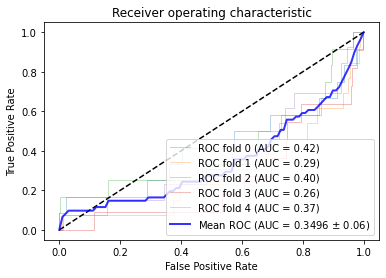

accuracy : 0.98125


In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn import svm
import matplotlib.pyplot as plt

# create model
clf = svm.SVC(kernel='poly', C=1, probability=True)

history = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5, shuffle=True)
for i, (train, val) in enumerate(cv.split(X_train, y_train)):
    X_train, X_val = X[train], X[val]
    y_train, y_val = y[train], y[val]

    # Fit model
    clf.fit(X_train, y_train)

    # Predict
    predict = clf.predict(X_val)
    clf_probs = clf.predict_proba(X_val)

    # Store model report in history list
    history.append(classification_report(y_val, predict))

    # Get loss and accuracy
    acc = accuracy_score(y_val, predict)
    loss = log_loss(y_val, clf_probs)
    print(f'====================Fold {i+1}====================', '\n')
    print(f"accuracy_score : {acc}")
    print(f"log_loss : {loss}\n")

    viz = RocCurveDisplay.from_estimator(clf, X_val, y_val, name="ROC fold {}".format(i), alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

# middle line
ax.plot([0, 1], [0, 1], 'k--')

# mean line
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.4f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

'''
# std
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)'''

ax.set(xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic")

ax.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig('graph\\3_svm_poly.jpg')

plt.show()

predict = clf.predict(X_test)
print(f"accuracy : {accuracy_score(y_test, predict)}")

# for i in range(len(history)):
    # print(f'=========================Fold {i+1}=========================')
    # print(history[i])

====================Fold 1==================== 

accuracy_score : 0.9837251356238698
log_loss : 0.082281789856579



C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

====================Fold 2==================== 

accuracy_score : 0.976491862567812
log_loss : 0.1136324541148989

====================Fold 3==================== 

accuracy_score : 0.9836956521739131
log_loss : 0.08484311374777667

====================Fold 4==================== 

accuracy_score : 0.9855072463768116
log_loss : 0.07668679121536436



C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

====================Fold 5==================== 

accuracy_score : 0.9818840579710145
log_loss : 0.09095589443650662



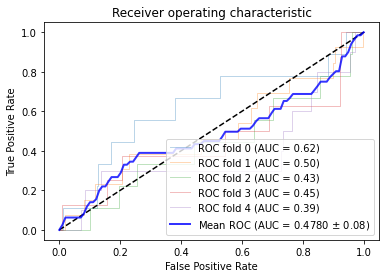

accuracy : 0.98125


In [25]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn import svm
import matplotlib.pyplot as plt

# create model
clf = svm.SVC(kernel='rbf', C=1, probability=True)

history = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5, shuffle=True)
for i, (train, val) in enumerate(cv.split(X_train, y_train)):
    X_train, X_val = X[train], X[val]
    y_train, y_val = y[train], y[val]

    # Fit model
    clf.fit(X_train, y_train)

    # Predict
    predict = clf.predict(X_val)
    clf_probs = clf.predict_proba(X_val)

    # Store model report in history list
    history.append(classification_report(y_val, predict))

    # Get loss and accuracy
    acc = accuracy_score(y_val, predict)
    loss = log_loss(y_val, clf_probs)
    print(f'====================Fold {i+1}====================', '\n')
    print(f"accuracy_score : {acc}")
    print(f"log_loss : {loss}\n")

    viz = RocCurveDisplay.from_estimator(clf, X_val, y_val, name="ROC fold {}".format(i), alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

# middle line
ax.plot([0, 1], [0, 1], 'k--')

# mean line
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.4f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

'''
# std
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)'''

ax.set(xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic")

ax.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig('graph\\3_svm_rbf.jpg')

plt.show()

predict = clf.predict(X_test)
print(f"accuracy : {accuracy_score(y_test, predict)}")

# for i in range(len(history)):
    # print(f'=========================Fold {i+1}=========================')
    # print(history[i])

====================Fold 1==================== 

accuracy_score : 0.9705882352941176
log_loss : 0.129238722140598

====================Fold 2==================== 

accuracy_score : 0.9751131221719457
log_loss : 0.11194290827591305

====================Fold 3==================== 

accuracy_score : 0.9819004524886877
log_loss : 0.08473902246410846

====================Fold 4==================== 

accuracy_score : 0.9909502262443439
log_loss : 0.054481067585038276

====================Fold 5==================== 

accuracy_score : 0.9796380090497737
log_loss : 0.09305202776041771



C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

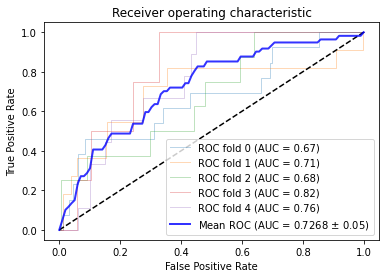

accuracy : 0.98125


In [26]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# create model
clf = LogisticRegression()

history = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5, shuffle=True)
for i, (train, val) in enumerate(cv.split(X_train, y_train)):
    X_train, X_val = X[train], X[val]
    y_train, y_val = y[train], y[val]

    # Fit model
    clf.fit(X_train, y_train)

    # Predict
    predict = clf.predict(X_val)
    clf_probs = clf.predict_proba(X_val)

    # Store model report in history list
    history.append(classification_report(y_val, predict))

    # Get loss and accuracy
    acc = accuracy_score(y_val, predict)
    loss = log_loss(y_val, clf_probs)
    print(f'====================Fold {i+1}====================', '\n')
    print(f"accuracy_score : {acc}")
    print(f"log_loss : {loss}\n")

    viz = RocCurveDisplay.from_estimator(clf, X_val, y_val, name="ROC fold {}".format(i), alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

# middle line
ax.plot([0, 1], [0, 1], 'k--')

# mean line
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.4f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

'''
# std
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)'''

ax.set(xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic")

ax.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig('graph\\3_lg.jpg')

plt.show()

predict = clf.predict(X_test)
print(f"accuracy : {accuracy_score(y_test, predict)}")

# for i in range(len(history)):
    # print(f'=========================Fold {i+1}=========================')
    # print(history[i])

====================Fold 1==================== 

accuracy_score : 0.9830508474576272
log_loss : 0.24252385708649188

====================Fold 2==================== 

accuracy_score : 0.9830508474576272
log_loss : 0.5985754905481473

====================Fold 3==================== 

accuracy_score : 0.9774011299435028
log_loss : 0.6133001363855344



C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

====================Fold 4==================== 

accuracy_score : 0.9830028328611898
log_loss : 0.6035451937746006

====================Fold 5==================== 

accuracy_score : 0.9773371104815864
log_loss : 0.615236142307103



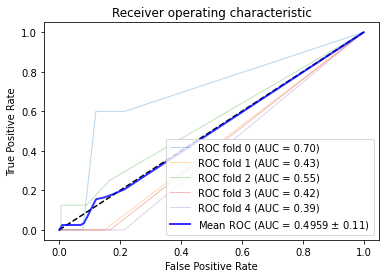

accuracy : 0.9916666666666667


In [27]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# create model
clf = RandomForestClassifier(n_estimators=40)

history = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5, shuffle=True)
for i, (train, val) in enumerate(cv.split(X_train, y_train)):
    X_train, X_val = X[train], X[val]
    y_train, y_val = y[train], y[val]

    # Fit model
    clf.fit(X_train, y_train)

    # Predict
    predict = clf.predict(X_val)
    clf_probs = clf.predict_proba(X_val)

    # Store model report in history list
    history.append(classification_report(y_val, predict))

    # Get loss and accuracy
    acc = accuracy_score(y_val, predict)
    loss = log_loss(y_val, clf_probs)
    print(f'====================Fold {i+1}====================', '\n')
    print(f"accuracy_score : {acc}")
    print(f"log_loss : {loss}\n")

    viz = RocCurveDisplay.from_estimator(clf, X_val, y_val, name="ROC fold {}".format(i), alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

# middle line
ax.plot([0, 1], [0, 1], 'k--')

# mean line
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.4f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

'''
# std
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)'''

ax.set(xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic")

ax.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig('graph\\3_rf.jpg')

plt.show()

predict = clf.predict(X_test)
print(f"accuracy : {accuracy_score(y_test, predict)}")

# for i in range(len(history)):
    # print(f'=========================Fold {i+1}=========================')
    # print(history[i])

====================Fold 1==================== 

accuracy_score : 0.9717314487632509
log_loss : 0.13588365565852142

====================Fold 2==================== 

accuracy_score : 0.9893992932862191
log_loss : 0.08118797087601841

====================Fold 3==================== 

accuracy_score : 0.9787985865724381
log_loss : 0.1004744465042507

====================Fold 4==================== 

accuracy_score : 0.9858657243816255
log_loss : 0.06935824083585417

====================Fold 5==================== 

accuracy_score : 0.9964664310954063
log_loss : 0.03815683470337637



C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

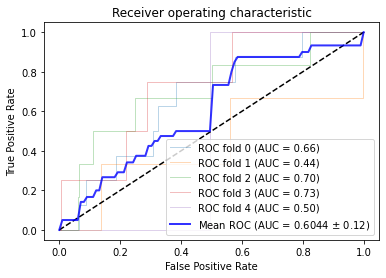

accuracy : 0.98125


In [28]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt

# create model
clf = GaussianNB()

history = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5, shuffle=True)
for i, (train, val) in enumerate(cv.split(X_train, y_train)):
    X_train, X_val = X[train], X[val]
    y_train, y_val = y[train], y[val]

    # Fit model
    clf.fit(X_train, y_train)

    # Predict
    predict = clf.predict(X_val)
    clf_probs = clf.predict_proba(X_val)

    # Store model report in history list
    history.append(classification_report(y_val, predict))

    # Get loss and accuracy
    acc = accuracy_score(y_val, predict)
    loss = log_loss(y_val, clf_probs)
    print(f'====================Fold {i+1}====================', '\n')
    print(f"accuracy_score : {acc}")
    print(f"log_loss : {loss}\n")

    viz = RocCurveDisplay.from_estimator(clf, X_val, y_val, name="ROC fold {}".format(i), alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

# middle line
ax.plot([0, 1], [0, 1], 'k--')

# mean line
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.4f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

'''
# std
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)'''

ax.set(xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic")

ax.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig('graph\\3_nb.jpg')

plt.show()

predict = clf.predict(X_test)
print(f"accuracy : {accuracy_score(y_test, predict)}")

# for i in range(len(history)):
    # print(f'=========================Fold {i+1}=========================')
    # print(history[i])